In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3b1t8c6s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3b1t8c6s
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 774.2 kB/s eta 0:00:000:00:01
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=7647c8defa8b74155a45cf483fe9217ef8cfeee625b027478b72c130cf3855af
  Stored in directory: /tmp/pip-ephem-wheel-cache-ukcohlx3/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


## 1

In [2]:
import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import clip

device = "cuda:0" if torch.cuda.is_available() else "cpu"

resnet50_imagenet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)

clip_model, preprocess = clip.load("RN50", device=device)
clip_image_encoder = clip_model.visual.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s] 
100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 132MiB/s]


The architecture of the pretrained ResNet-50 (RN50) model is identical to that of the standard ResNet-50 model; however, weights are initialised by ImageNet pretraining. Because of its extensive training on the ImageNet dataset, this model performs exceptionally well on image classification tasks.

On the other hand, the visual encoder in OpenAI's CLIP model is built on a modified ResNet architecture, namely ResNet-50x4. With this update, the ResNet-50 architecture's visual understanding performance for the CLIP task is improved by a factor of 4. Additional training on a large dataset of image-text pairs has allowed the vision encoder of the CLIP model to learn features that are useful for both classification and for comprehending the semantic relationship between images and text.

## 2

In [3]:
def get_imagenet_labels():
    import json
    with open('/kaggle/input/imagenet-labels/imagenet_labels.json', 'r') as file:
        json_data = json.load(file)
    labels = {int(idx):label for idx, label in json_data.items()}
    return labels

IMAGENET_LABELS = get_imagenet_labels()

(i):
The ImageNet dataset uses a label hierarchy based on the WordNet lexical database. WordNet organizes words into sets called synsets, which represent distinct concepts or ideas. In ImageNet, each synset corresponds to a specific category or class of objects. For example, the synset "n02123159" represents the category "tiger cat."

(ii):
A synset is a set of synonymous words or terms that represent a distinct concept or idea. Synsets are used to group related words together based on their semantic similarity. In the context of ImageNet, each synset contains words that are considered synonymous or closely related within a specific category.

(iii):
Objects inside the same synset can have notable visual distinctions so grouping things based on synsets may cause issues with visual identification.

(iv): **Visual Differences**
- Intra-class Variation: Objects within the same synset may exhibit significant visual variations, such as different breeds of dogs.
- Viewpoint and Scale Changes: Objects belonging to the same synset may appear differently based on viewpoint, scale, orientation, or lighting conditions. For instance, a dog viewed from different angles may look distinct despite being the same breed.
- Occlusion and Background Clutter: Objects in the same synset can be occluded by other objects or surrounded by background clutter, affecting their visual appearance and making recognition challenging.

In [4]:
print(device)

cuda:0


## 3

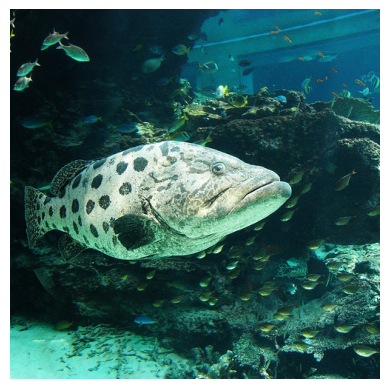

puffer, pufferfish, blowfish, globefish
electric ray, crampfish, numbfish, torpedo
loggerhead, loggerhead turtle, Caretta caretta
tiger shark, Galeocerdo cuvieri
eel



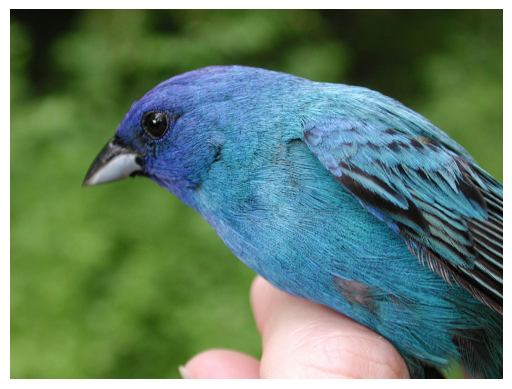

indigo bunting, indigo finch, indigo bird, Passerina cyanea
jay
peacock
jacamar
bulbul



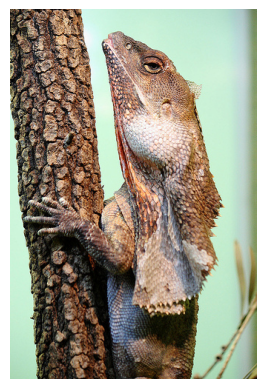

frilled lizard, Chlamydosaurus kingi
Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis
African chameleon, Chamaeleo chamaeleon
common iguana, iguana, Iguana iguana
American chameleon, anole, Anolis carolinensis



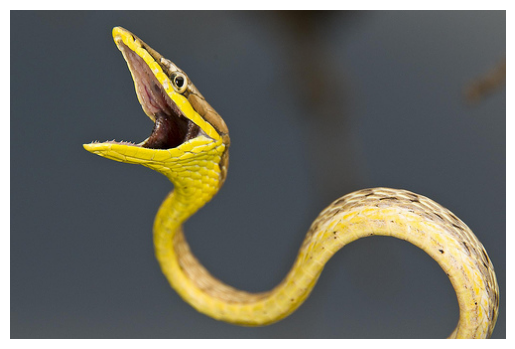

vine snake
eel
garter snake, grass snake
ringneck snake, ring-necked snake, ring snake
whiptail, whiptail lizard



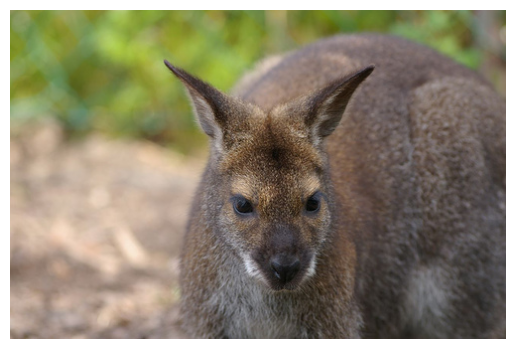

wallaby, brush kangaroo
dhole, Cuon alpinus
dingo, warrigal, warragal, Canis dingo
koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
wombat



In [5]:
import torch
import clip
import os
from PIL import Image
import matplotlib.pyplot as plt

classes_list = [IMAGENET_LABELS[idx] for idx in range(len(IMAGENET_LABELS))]

random_images_dir = '/kaggle/input/imagenetmini-1000/imagenet-mini/train'
random_images = [random_images_dir + '/n01496331/n01496331_23066.JPEG',
                    random_images_dir + '/n01537544/n01537544_31.JPEG',
                    random_images_dir + '/n01688243/n01688243_8387.JPEG',
                    random_images_dir + '/n01739381/n01739381_2140.JPEG',
                    random_images_dir + '/n01877812/n01877812_10564.JPEG']

with torch.no_grad():
    text_features = clip_model.encode_text(clip.tokenize(classes_list).to(device))

def clip_score(image_features):
    sim_scores = torch.cosine_similarity(image_features, text_features.unsqueeze(0), dim=-1)
    probs = torch.softmax(sim_scores, dim=-1)
    return probs
    
for image_path in random_images:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_image_encoder(image)

    probs = clip_score(image_features)
    top5_probs, top5_classes = torch.topk(probs, 5)
 
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    for i in range(5):
        print(f'{classes_list[top5_classes[0][i]]}')
    print()

## 4

In [6]:
import random
random.seed(0)
random_labels = random.sample(classes_list, 10)
print(random_labels)

['tow truck, tow car, wrecker', 'sturgeon', 'sax, saxophone', 'wool, woolen, woollen', 'basketball', 'whiptail, whiptail lizard', 'toy poodle', 'acorn', 'crutch', 'church, church building']


In [7]:
example_images_dir = '/kaggle/input/imagenetmini-1000/imagenet-mini/train'
example_images = [example_images_dir + '/n04461696/n04461696_2218.JPEG',
                     example_images_dir + '/n02640242/n02640242_3784.JPEG',
                     example_images_dir + '/n04141076/n04141076_34030.JPEG',
                     example_images_dir + '/n04599235/n04599235_3345.JPEG',
                     example_images_dir + '/n02802426/n02802426_4600.JPEG',
                     example_images_dir + '/n01685808/n01685808_5291.JPEG',
                     example_images_dir + '/n02113624/n02113624_4518.JPEG',
                     example_images_dir + '/n12267677/n12267677_3433.JPEG',
                     example_images_dir + '/n03141823/n03141823_3068.JPEG',
                     example_images_dir + '/n03028079/n03028079_7287.JPEG']

In [8]:
j = 0
for image_path in example_images:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_image_encoder(image)

    clip_probs = clip_score(image_features)
    clip_top5_probs, clip_top5_classes = torch.topk(clip_probs, 5)

    print("Label: " + random_labels[j])
    
    print("CLIP-----------------------------")
    for i in range(5):
        print(f'{classes_list[clip_top5_classes[0][i]]}')
    print()

    resnet50_imagenet.eval()
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    resnet_probs = resnet50_imagenet(image)
    resnet_probs = torch.nn.functional.softmax(resnet_probs, dim=1)
    resnet_top5_probs, resnet_top5_classes = torch.topk(resnet_probs, 5)

    print("ResNet50-------------------------")
    for i in range(5):
        print(f'{classes_list[resnet_top5_classes[0][i]]}')

    print("---------------------------------")
    print()
    
    j = j + 1

Label: tow truck, tow car, wrecker
CLIP-----------------------------
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
tow truck, tow car, wrecker
ambulance
cab, hack, taxi, taxicab
fire engine, fire truck

ResNet50-------------------------
tow truck, tow car, wrecker
pickup, pickup truck
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
Model T
jeep, landrover
---------------------------------

Label: sturgeon
CLIP-----------------------------
sturgeon
gar, garfish, garpike, billfish, Lepisosteus osseus
barracouta, snoek
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias

ResNet50-------------------------
sturgeon
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
barracouta, snoek
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
gar, garfish, garpike, billfish, Lepisosteus osseus
----

### 4.1

In [59]:
sketch_images_dir = '/kaggle/input/imagenetsketch/sketch'
sketch_images = [sketch_images_dir + '/n04461696/sketch_10.JPEG',
                     sketch_images_dir + '/n04461696/sketch_11.JPEG',
                     sketch_images_dir + '/n02640242/sketch_0.JPEG',
                     sketch_images_dir + '/n02640242/sketch_11.JPEG',
                     sketch_images_dir + '/n04141076/sketch_14.JPEG',
                     sketch_images_dir + '/n04141076/sketch_15.JPEG',
                     sketch_images_dir + '/n04599235/sketch_12.JPEG',
                     sketch_images_dir + '/n04599235/sketch_13.JPEG',
                     sketch_images_dir + '/n02802426/sketch_0.JPEG',
                     sketch_images_dir + '/n02802426/sketch_1.JPEG',
                     sketch_images_dir + '/n01685808/sketch_10.JPEG',
                     sketch_images_dir + '/n01685808/sketch_11.JPEG',
                     sketch_images_dir + '/n02113624/sketch_12.JPEG',
                     sketch_images_dir + '/n02113624/sketch_1.JPEG',
                     sketch_images_dir + '/n12267677/sketch_10.JPEG',
                     sketch_images_dir + '/n12267677/sketch_12.JPEG',
                     sketch_images_dir + '/n03141823/sketch_12.JPEG',
                     sketch_images_dir + '/n03141823/sketch_13.JPEG',
                     sketch_images_dir + '/n03028079/sketch_10.JPEG',
                     sketch_images_dir + '/n03028079/sketch_11.JPEG']

In [60]:
j = 0
k = 0

for image_path in sketch_images:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_image_encoder(image)

    clip_probs = clip_score(image_features)
    clip_top5_probs, clip_top5_classes = torch.topk(clip_probs, 5)

    print("Label: " + random_labels[j])
    
    print("CLIP-----------------------------")
    for i in range(5):
        print(f'{classes_list[clip_top5_classes[0][i]]}')
    print()

    resnet50_imagenet.eval()
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    resnet_probs = resnet50_imagenet(image)
    resnet_probs = torch.nn.functional.softmax(resnet_probs, dim=1)
    resnet_top5_probs, resnet_top5_classes = torch.topk(resnet_probs, 5)

    print("ResNet50-------------------------")
    for i in range(5):
        print(f'{classes_list[resnet_top5_classes[0][i]]}')

    print("---------------------------------")
    print()
    
    k = k + 1
    if k % 2 == 0:
        j = j + 1

Label: tow truck, tow car, wrecker
CLIP-----------------------------
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
tow truck, tow car, wrecker
forklift
moving van
pickup, pickup truck

ResNet50-------------------------
maze, labyrinth
envelope
hair slide
studio couch, day bed
half track
---------------------------------

Label: tow truck, tow car, wrecker
CLIP-----------------------------
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
tow truck, tow car, wrecker
minibus
forklift
amphibian, amphibious vehicle

ResNet50-------------------------
envelope
maze, labyrinth
rubber eraser, rubber, pencil eraser
tray
safety pin
---------------------------------

Label: sturgeon
CLIP-----------------------------
gar, garfish, garpike, billfish, Lepisosteus osseus
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
tiger shark, Galeocerdo cuvieri
coho, cohoe, coho salmon, blue jack, silver salmo

Here, in most of the classes, CLIP performs better than ResNet50.

### 4.2

In [94]:
image_path = '/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/n01443537/images/n01443537_100.JPEG'

image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = clip_image_encoder(image)

clip_probs = clip_score(image_features)
clip_top5_probs, clip_top5_classes = torch.topk(clip_probs, 5)

print("Label: goldfish, Carassius auratus")
    
print("CLIP-----------------------------")
for i in range(5):
    print(f'{classes_list[clip_top5_classes[0][i]]}')
print()

resnet50_imagenet.eval()
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
resnet_probs = resnet50_imagenet(image)
resnet_probs = torch.nn.functional.softmax(resnet_probs, dim=1)
resnet_top5_probs, resnet_top5_classes = torch.topk(resnet_probs, 5)

print("ResNet50-------------------------")
for i in range(5):
    print(f'{classes_list[resnet_top5_classes[0][i]]}')

print("---------------------------------")
print()
    
    #j = j + 1

Label: goldfish, Carassius auratus
CLIP-----------------------------
flatworm, platyhelminth
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
leafhopper
chiton, coat-of-mail shell, sea cradle, polyplacophore
electric ray, crampfish, numbfish, torpedo

ResNet50-------------------------
goldfish, Carassius auratus
rock beauty, Holocanthus tricolor
tench, Tinca tinca
electric ray, crampfish, numbfish, torpedo
anemone fish
---------------------------------



Here, ResNet50 performs better than CLIP.

(i) CLIP-performing images that do not perform well with ImageNet pretrained RN50:
       - Image 1: An artistic rendition of an object that ImageNet pretraining may have trouble with but CLIP's capacity for visual concept understanding may allow it to identify.
       - Image 2: An object in an uncommon or out-of-the-ordinary situation that ImageNet pretraining might not have identified, but CLIP might have because of its larger comprehension of visual relationships.
       
(ii) A single image that functions well with CLIP but not with ImageNet pretraining:
       - Image 1: A standard, uncomplicated image of an object that is well-represented in the ImageNet dataset, although because CLIP focuses more broadly on visual concepts, it might not be able to identify it as strongly.

## 5

### 5.1

In [64]:
import time
import numpy as np

image = '/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01518878/n01518878_22084.JPEG'

clip_image_encoder_fp16 = clip_image_encoder.half()

def encoding_time(image_encoder, image):
    start_time = time.time()
    with torch.no_grad():
        image = preprocess(Image.open(image)).unsqueeze(0).to(device)
        image_features = image_encoder(image)
    return time.time() - start_time

n_runs = 100
times_16 = []
times_32 = []

for _ in range(n_runs):
    times_16.append(encoding_time(clip_image_encoder_fp16, image))

mean_time_fp16 = np.mean(times_16)
std_time_fp16 = np.std(times_16)

for _ in range(n_runs):
    times_32.append(encoding_time(clip_image_encoder, image))

mean_time_fp32 = np.mean(times_32)
std_time_fp32 = np.std(times_32)

print(f"Mean time for fp16 model: {mean_time_fp16} +/- {std_time_fp16}")
print(f"Mean time for fp32 model: {mean_time_fp32} +/- {std_time_fp32}")

diff_time = abs(mean_time_fp16 - mean_time_fp32)
print(f"Difference between fp32 and fp16 models: {diff_time}")

Mean time for fp16 model: 0.015936472415924073 +/- 0.0004672342176832385
Mean time for fp32 model: 0.01616011142730713 +/- 0.0007400572731232952
Difference between fp32 and fp16 models: 0.0002236390113830554


FP16 takes lesser time than FP32.

### 5.2

In [19]:
example_images = example_images[:5]
for image_path in example_images:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    image_features_fp32 = clip_image_encoder(image)
    clip_probs_fp32 = clip_score(image_features_fp32)
    clip_top5_probs32, clip_top5_classes32 = torch.topk(clip_probs_fp32, 5)

    image_features_fp16 = clip_image_encoder_fp16(image)
    clip_probs_fp16 = clip_score(image_features_fp16)
    clip_top5_probs16, clip_top5_classes16 = torch.topk(clip_probs_fp16, 5)

    print("Image:", image_path)
    print("FP32 model:")
    for i in range(5):
        print(f'{classes_list[clip_top5_classes32[0][i]]}: {clip_top5_probs32[0][i]}')
    print()
    
    print("FP16 model:")
    for i in range(5):
        print(f'{classes_list[clip_top5_classes16[0][i]]}: {clip_top5_probs16[0][i]}')
    print("------------------------------------------------------")
    print()

Image: /kaggle/input/imagenetmini-1000/imagenet-mini/train/n04461696/n04461696_2218.JPEG
FP32 model:
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria: 0.0011434555053710938
tow truck, tow car, wrecker: 0.0011196136474609375
ambulance: 0.0011081695556640625
cab, hack, taxi, taxicab: 0.0011072158813476562
fire engine, fire truck: 0.0011005401611328125

FP16 model:
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria: 0.0011434555053710938
tow truck, tow car, wrecker: 0.0011196136474609375
ambulance: 0.0011081695556640625
cab, hack, taxi, taxicab: 0.0011072158813476562
fire engine, fire truck: 0.0011005401611328125
-----------------------------------

Image: /kaggle/input/imagenetmini-1000/imagenet-mini/train/n02640242/n02640242_3784.JPEG
FP32 model:
sturgeon: 0.001140594482421875
gar, garfish, garpike, billfish, Lepisosteus osseus: 0.0011234283447265625
barracouta, snoek: 0.0011081695556640625
coho, cohoe, coho salmon, blue jack, silver salmon, O

The probabilities are almost the same for FP16 & FP32.

### 5.3

In [65]:
import warnings
# remove warnings
warnings.filterwarnings("ignore")

In [82]:
import torch.cuda as cuda

image = '/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01518878/n01518878_22084.JPEG'
cuda.reset_max_memory_allocated()
with torch.no_grad():
    image = preprocess(Image.open(image)).unsqueeze(0).to(device)
    image_features_fp32 = clip_image_encoder(image)
max_memory_fp32 = cuda.memory_allocated() / 1024 / 1024
memory_reserved_fp32 = cuda.memory_reserved() / 1024 / 1024
print(f"Memory usage for fp32 model: {max_memory_fp32} MB")
print(f"Memory reserved for fp32 model: {memory_reserved_fp32} MB")

Memory usage for fp32 model: 537.91259765625 MB
Memory reserved for fp32 model: 2544.0 MB


In [83]:
image = '/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01518878/n01518878_22084.JPEG'
cuda.reset_max_memory_allocated()
with torch.no_grad():
    image = preprocess(Image.open(image)).unsqueeze(0).to(device)
    image_features_fp16 = clip_image_encoder_fp16(image)
max_memory_fp16 = cuda.memory_allocated() / 1024 / 1024
memory_reserved_fp16 = cuda.memory_reserved() / 1024 / 1024
print(f"Memory usage for fp16 model: {max_memory_fp16} MB")
print(f"Memory reserved for fp16 model: {memory_reserved_fp16} MB")

Memory usage for fp16 model: 537.91259765625 MB
Memory reserved for fp16 model: 2544.0 MB


Memory used by fp16 will be lesser than that used by fp32 because each paramter is fp16 is stored using 16 bits whereas in fp32, it is stored using 32 bits.

In [88]:
image = '/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01518878/n01518878_22084.JPEG'
torch.cuda.reset_peak_memory_stats()

torch.cuda.memory._record_memory_history(max_entries=100000)
image = preprocess(Image.open(image)).unsqueeze(0).to(device)
output = clip_image_encoder_fp16(image)
torch.cuda.memory._dump_snapshot("fp16-model")

torch.cuda.memory._record_memory_history(enabled=None)
print(torch.cuda.memory._record_memory_history(enabled=None))

None
